# Support Vector Machines using cvxopt


This blog post is about implementing Support Vector Machines from scratch using CVXOPT.
We will go through the math behind the SVM method and test out the kernel RBF and linear kernel on generated data.

In [143]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxmat
from cvxopt import solvers as solver
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [144]:
def generate_data(n_samples=200, n_features=2, centers=2, center_box=(-15., 15.), cluster_std=1.):
    """Generates the clusters for testing linear SVMs
    
    Args:
        n_samples: An integer for the number of data points to be generated.
        n_features: An integer for the number of the columns in the output data.
        centers: An integer for the number of cluster to generate.
        center_box: A tuple of float for the location of the clusters.
        cluster: A float that controls the standard deviation of the clusters.
    """
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers,
                      center_box=center_box, cluster_std=cluster_std)
    y[y == 0] = -1 
    y = y.astype(float)
    
    st = StandardScaler()
    X_s = st.fit_transform(X)
    return X_s, y

In [145]:
X, y = generate_data()

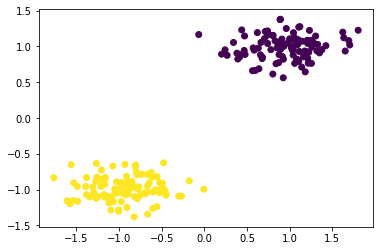

In [146]:
plt.scatter(X[:, 0], X[:, 1], c=y)

Here are two linearly separable clusters that we will use to test the Hard Margin SVM method.

## The kernel Trick
First let's define the kernel trick to understand the magic of SVMs.
A kernel function $\kappa(\boldsymbol{x}, \boldsymbol{x^{'}})$ is a measure of similarity between two objects $\boldsymbol{x}, \boldsymbol{x^{'}} \in \chi$ where $\chi$ is an abstract space of higher dimension. Let's assume that we have $\boldsymbol{X}$ a non-linearly separable data. We would like to transform the data into a higher dimensional space to make it linearly separable. Let us define $\phi$ a function that maps the data into a higher dimensional space. A classical approach would be to compute $\phi(\boldsymbol{X})$ but this transformation may be very computationally heavy. Instead we use the kernel trick.

The kernel trick method stands for calculating the relationship of data in higher dimension without actually transforming the data in this target space. The kernel trick reduces the amount of computation required for kernelized algorithms. The main idea is, instead of computing $\phi(\boldsymbol{X})$, we will compute the dot product $\phi(\boldsymbol{X}_i)^\top\phi(\boldsymbol{X}_j)$ for all the components of $\boldsymbol{X}$. In other words, we will know the relationship of the data in higher dimension, without ever computing the transformation of the whole data.

The kernel function is defined as:
$$
\kappa(\boldsymbol{x}, \boldsymbol{x^{'}}) = \phi(\boldsymbol{x})^\top \phi(\boldsymbol{x^{'}})
$$

The kernel function has the following properties:
$$
\begin{align}
                \kappa(\boldsymbol{x}, \boldsymbol{x^{'}}) &\in \mathbb{R} \\
                \kappa(\boldsymbol{x}, \boldsymbol{x}^{'}) &= \kappa(\boldsymbol{x}^{'}, \boldsymbol{x}) \\
                \kappa(\boldsymbol{x}, \boldsymbol{x^{'}}) &\geq 0 \\
            \end{align}
$$
There is a multitude of different kernels like:
$$
            \begin{align}
                \kappa(\boldsymbol{x}, \boldsymbol{x^{'}}) &= \boldsymbol{x}^\top \boldsymbol{x}^{'} && \text{linear kernel} \\
                \kappa(\boldsymbol{x}, \boldsymbol{x^{'}}) &= \left(\boldsymbol{x}^\top \boldsymbol{x^{'}} + r\right)^d && \text{polynomial kernel} \\
                \kappa(\boldsymbol{x}, \boldsymbol{x^{'}}) &= \exp\left(-\frac{|| \boldsymbol{x} -  \boldsymbol{x^{'}} ||^2}{2\sigma^{2}}\right) && \text{kernel RBF} \\
            \end{align}
$$<br>
where $r$ is the coefficient of the polynomial and $d$ its degree, while $\sigma$ is known as the bandwith of the radial basis function (RBF).

## Hard Margin Classifier
Support vector machines} were originally designed for binary classification but can be extended to regression and multi-class classification.
SVMs are not probabilistic models, their output is a raw prediction. We will only discuss how SVMs work for classification. Let's get the basic intuition with the help of the following figure.

<div style="text-align:center"><img src="images/300px-SVM_margin.png" /></div>

SVMs separate the data in two classes using a hyperplane. The distance between the dotted hyperplanes and the hyperplane at the center is known as margin.
A margins is passing by one of multiple points, these points are known as support vectors.
Any point above the red hyperplane will be classified as $1$ respectively $-1$ for the points below the hyperplane.
In order to predict on an input sample $\boldsymbol{x}$, we compute the linear equation:
$$
\begin{align}
    f(\boldsymbol{x}) &= \boldsymbol{w}^\top \boldsymbol{x} + b \\
    \hat{y} &= 
    \begin{cases}
        \;\;\;1 & \text{if} \quad f(\boldsymbol{x}) \geq 0 \\
        -1 & \text{otherwise}
    \end{cases}
\end{align}
$$

SVMs try to maximize the margin when separating the data. This fact plays a role in the generalization of SVM models. We can find the value of the margin by solving the equation:
$$
    \begin{align}
        \boldsymbol{w}^\top (\boldsymbol{x}_2 - \boldsymbol{x}_1) &= 2 \\
        \frac{\boldsymbol{w}^\top}{||\boldsymbol{w}||} (\boldsymbol{x}_2 - \boldsymbol{x}_1) &= \frac{2}{||\boldsymbol{w}||}
    \end{align}
$$

In other words, the optimization problem to solve when training an SVM is to solve the optimization problem known as primal
$$
    \begin{equation}
        \min_{\boldsymbol{w}, b}\frac{1}{2}||\boldsymbol{w}||^2 \quad \text{s.t} \quad y_i(\boldsymbol{w}^\top \boldsymbol{x}_i + b) \geq 1, \quad \forall i \in \{1, \dots, N\}
    \end{equation}
$$

The reason we minimize $||\boldsymbol{w}||^2$ instead of $||\boldsymbol{w}||$ is that minimizing the second option is non-convex.
The condition ensures that all samples are on the right side of the hyperplane. Note that this classifier does not allow any misclassification and is known as hard margin classifier.


## Primal form to Dual form
The primal for is not suited to implementation because of the fact that it is a constrained optimization.
We can use the generalized Lagrangian to get its dual form that more feasible constrained:
$$
    \begin{equation}
        \min_{\boldsymbol{x}, b}L(\boldsymbol{x}, b, \boldsymbol{\sigma}) = \frac{1}{2}||\boldsymbol{w}||^2 - \sum_{i=1}^{N} \sigma_i y_i(\boldsymbol{w}^\top \phi(\boldsymbol{x}_i) + b - 1)
        \label{eq:lagrange}
    \end{equation}
$$

We also need to satisfy the KKT conditions, such as:
$$
    \begin{align}
        \frac{\partial L}{\partial \boldsymbol{w}} = \boldsymbol{w} - \sum_{i=1}^{N} \sigma_i y_i\phi(\boldsymbol{x}_i) &= 0 \Rightarrow \boldsymbol{w} = \sum_{i=1}^{N} \sigma_i y_i\phi(\boldsymbol{x}_i) \\
        \frac{\partial L}{\partial \boldsymbol{b}} = -\sum_{i=1}^{N}\sigma_i y_i &= 0 \Rightarrow \sum_{i=1}^{N}\sigma_i y_i = 0
    \end{align}
$$

Because the dual problem is a lower bound of the primal problem, we need to maximize the equation above:
$$
    \begin{equation}
        \max_{\boldsymbol{\sigma}}\min_{\boldsymbol{x}, b}L(\boldsymbol{x}, b, \boldsymbol{\sigma}) \sim \min_{\boldsymbol{w}}f(\boldsymbol{x})
    \end{equation}
$$

By substituting the formulas that we got thanks to the KKT conditions in $L$ we get the final dual form:
$$
    \begin{align}
        &\max_{\boldsymbol{\sigma}} \: \sum_{i=1}^{N}\sigma_i - \frac{1}{2} \sum_{i=1}^{N}\sum_{j=1}^{N} \sigma_i \sigma_j y_i y_j \phi(\boldsymbol{x}_i)^\top \phi(\boldsymbol{x}_j) \\
        &\text{s.t.} \quad \sigma_i \geq 0 && \forall i \in \{1, \dots, N\}\\
        &\text{s.t.} \quad \sum_{i=1}^{N}\sigma_iy_i = 0 && \forall i \in \{1, \dots, N\}\\
    \end{align}
$$

Then, we transform the optimization problem into a minimization and introducting the Gram matrix $\boldsymbol{K}_{ij} = \phi(\boldsymbol{x}_i)^\top \phi(\boldsymbol{x}_j)$:
$$
    \begin{align}
    &\min_{\boldsymbol{\sigma}; \boldsymbol{\sigma} \geq 0}  \frac{1}{2} \sum_{i=1}^{N}\sum_{j=1}^{N} \sigma_i \sigma_j y_i y_j \boldsymbol{K}_{ij} -  \sum_{i=1}^{N}\sigma_i \\
        &\text{s.t.} \quad \sigma_i \geq 0 && \forall i \in \{1, \dots, N\}\\
        &\text{s.t.} \quad \sum_{i=1}^{N}\sigma_iy_i = 0 && \forall i \in \{1, \dots, N\}\\
    \end{align}
$$

If the data is not linearly separable, even after using the kernel trick, we can use a soft margin classifier.

## Soft Margin Classifier
Soft-margin classifiers introduce slack variables $\zeta_i \geq 0$ as $\zeta_i = |y_i - f_i|$ to allow the classifier to mis-classify some samples.

<div style="text-align:center"><img src="images/softmargin.png" /></div>

In fact, we allow the model to make mistakes to be able to separate non linearly separable data where:
- $\zeta_i = 0$ means that the point lies in the correct margin boundary.
- $0 < \zeta_i \leq 1$ the point lies inside the margin and on the correct side.
- $\zeta_i > 1$ the point lies in the incorrect boundary.

The primal optimization is then:
$$
    \begin{align}
        &\min_{\boldsymbol{w}, b}\frac{1}{2}||\boldsymbol{w}||^2 - C\sum_{i=1}^{N}\zeta_i\\
        &\text{s.t} \quad y_i(\boldsymbol{w}^\top \boldsymbol{x}_i + b) \geq 1 - \zeta_i, && \forall i \in \{1, \dots, N\} \\
        &\text{s.t} \quad \zeta_i \geq 0 && \forall i \in \{1, \dots, N\}
    \end{align}
$$
where $C$ is the regularization parameter that controls the number of errors we are willing to tolerate on the training set.
            
Then the dual problem for the soft margin model is:
$$
    \begin{align}
        &\max_{\boldsymbol{\sigma}}\sum_{i=1}^{N}\sigma_i - \frac{1}{2} \sum_{i=1}^{N}\sum_{j=1}^{N} \sigma_i \sigma_j y_i y_j \phi(\boldsymbol{x}_i)^\top \phi(\boldsymbol{x}_j) \\
        &\text{s.t.} \quad 0 \leq \sigma_i \leq C && \forall i \in \{1, \dots, N\}\\
        &\text{s.t.} \quad \sum_{i=1}^{N}\sigma_iy_i = 0 && \forall i \in \{1, \dots, N\}\\
    \end{align}
$$

## Implementation
We will compute the convex optimizations using the CVXOPT package.
The solver performs the following optimization:
$$
    \min \frac{1}{2} \boldsymbol{\sigma}^\top \boldsymbol{P} \boldsymbol{\sigma} - 1^\top\boldsymbol{\sigma} \\
    \text{s.t.} \\
    - \sigma_i \leq 0 \\
    \boldsymbol{y}^\top \boldsymbol{\sigma} = 0
$$

As you have probably guess, we will have to convert the dual problem in matrix form, let's define:
$$
\begin{align}
    &P_{ij} = y_i y_j \boldsymbol{K}_{ij} \\
    &\boldsymbol{w} = \sum_{i=1}^{N} y_i \sigma_i\phi(\boldsymbol{x}_i) \\
    &b = y_s - \sum_{m \in S} \sigma_m y_m \phi(\boldsymbol{x}_m)^\top \phi(\boldsymbol{x}_s) \\
\end{align}
$$
where $S$ is the set of support vectors such as $\sigma_i > 0$.<br>
We can solve the hard margin optimization problem by solving:
$$
\begin{align}
    \min &\frac{1}{2} \boldsymbol{x}^\top\boldsymbol{P}\boldsymbol{x} + \boldsymbol{q}^\top\boldsymbol{x}\\
    &\text{s.t.} \\
    &\boldsymbol{G}\boldsymbol{x} \leq h \\
    &\boldsymbol{A}\boldsymbol{x} = 0
\end{align}
$$
where $h$ is a column of ones, $\boldsymbol{A}$ contains the labels and $\boldsymbol{G}$ is a diagonal matrix full of $-1$.

Here is the pseudo-algorithm for training an SVM:
- Compute $\boldsymbol{P}$.
- Compute $\boldsymbol{w}$.
- Find the support vectors $S$ by finding any data point where $\sigma_i > 0$.
- Compute $b$.
- To predict, compute:
$$
    y_{test} = \text{sign}\left(\boldsymbol{w}^\top \phi({\boldsymbol{x}_{test}}) + b \right)
$$
CVXOPT form:

In matrix form the dual optimization is:
$$
    \min \frac{1}{2} \boldsymbol{\sigma}^\top \boldsymbol{P} \boldsymbol{\sigma} - 1^\top\boldsymbol{\sigma} \\
    \text{s.t.} \\
    - \sigma_i \leq 0 \\
    \boldsymbol{y}^\top \boldsymbol{\sigma} = 0
$$

For training a soft margin classifier, we add a constraint on $C$:
$$
    \min \frac{1}{2} \boldsymbol{\sigma}^\top \boldsymbol{P} \boldsymbol{\sigma} - 1^\top\boldsymbol{\sigma} \\
    \text{s.t.} \\
    - \sigma_i \leq 0 \\
    \sigma_i \leq C \\
    \boldsymbol{y}^\top \boldsymbol{\sigma} = 0
$$

In [147]:
def linear_kernel(X_1, X_2):
    """Computes a dot product between two vectors"""
    return np.dot(X_1, X_2)

In [210]:
class SupportVectorClassifier():
    """Class for both the hard margin and soft margin classifier
    
    Attributes:
        kernel: A function for the kernel function to apply.
        C: If using soft margin, it is a float controling the tolerance to misclassification.
        sv_sigma: A torch tensor for the slack variables of the support vectors.
        sv: A torch tensor for the features of the support vectors.
        sv_y: A torch tensor for the labels of the support vectors.
        w: A torch tensor for the weights of the model, only used if using a linear kernel.
        b: A float for the bias.
    """
    def __init__(self, kernel, C=None):
        """Init function of the SVC"""
        self.kernel = kernel
        self.C = C
        
    def fit(self, X, y):
        """Trains the SVC model
        
        Args:
            X: A torch tensor for the data.
            y: A torch tensor for the labels.
        """
        # Building the cvxopt matrices
        if len(y.shape) == 1:
            y = np.expand_dims(y, axis=1)
        y = y.astype(float)
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i, :], X[j, :])
        q = cvxmat(np.ones((n_samples, 1)) * -1.)
        A = cvxmat(y.T)
        b = cvxmat(0.)
        P = cvxmat(np.outer(y, y) * K)
        
        if self.C is None:
            G = cvxmat(np.eye(n_samples) * -1.)
            h = cvxmat(np.zeros((n_samples, 1)))
        else:
            col_1 = np.eye(n_samples) * -1.
            col_2 = np.identity(n_samples)
            G = cvxmat(np.vstack((col_1, col_2)))
            
            col_1 = np.zeros(n_samples)
            col_2 = np.ones(n_samples) * self.C
            h = cvxmat(np.hstack((col_1, col_2)))
        
        # Compute the convex optimization
        sigma = np.array(solver.qp(P, q, G, h, A, b)['x'])
        
        # Gather support vectors
        sv_idx = sigma > 1e-5
        self.sv_sigma = np.expand_dims(sigma[sv_idx], axis=1)
        sv_idx = np.squeeze(sv_idx)
        self.sv = X[sv_idx, :]
        self.sv_y = y[sv_idx]
       
        # If linear kernel, compute w, otherwise compute it in pairs with
        # the data to predict
        if self.kernel == linear_kernel:
            w = np.sum(self.sv_y * self.sv_sigma * self.sv, axis=0)
            self.w = np.expand_dims(w, axis=1)
        else:
            self.w = None
        
        # Gather all pairwise distance of the support vectors
        idx = sv_idx.astype(int).nonzero()[0]
        b = 0
        sv_sigma_flat = self.sv_sigma.flatten()
        sv_y_flat = self.sv_y.flatten()
        for i in range(len(idx)):
            b += self.sv_y[i]
            b -= np.sum(sv_sigma_flat * sv_y_flat * K[idx[i], sv_idx])
        b /= len(idx)
        self.b = b
        
    def project(self, X):
        """Projects the data into the SVC hyperspace"""
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            pred = np.zeros(X.shape[0])
            for i in range(X.shape[0]):
                cur_pred = 0
                for j in range(self.sv_sigma.shape[0]):
                    cur_pred += self.sv_sigma[j] * self.sv_y[j] * self.kernel(X[i], self.sv[j])
                pred[i] = cur_pred
            return pred + self.b
    
    def predict(self, X):
        """Projects the data than return the sign of the prediction as label"""
        return np.sign(self.project(X))

## Hard Margin Classifier with Linear Kernel 

In [211]:
svc = SupportVectorClassifier(linear_kernel)
svc.fit(X, y)

     pcost       dcost       gap    pres   dres
 0: -1.6591e+02 -3.9116e+02  2e+02  4e-14  2e+00
 1: -3.5588e+02 -3.6335e+02  7e+00  5e-15  1e+00
 2: -1.7374e+04 -1.7380e+04  6e+00  7e-12  1e+00
 3: -5.0598e+07 -5.0598e+07  2e+02  1e-08  1e+00
 4: -5.4654e+10 -5.4655e+10  2e+05  2e-05  1e+00
Terminated (singular KKT matrix).


In [150]:
pred = svc.predict(X)

In [152]:
def plot_svc(X, y, svc, pred, plot_sv=True):
    """Plots the SVC hyperplane"""
    plt.scatter(X[:, 0], X[:, 1], c=y)
    if plot_sv:
        plt.scatter(svc.sv[:, 0], svc.sv[:, 1])
    axis_min, axis_max = plt.gca().get_xlim()
    
    w = svc.w
    
    a = -w[0] / w[1]
    xx = np.linspace(axis_min, axis_max)
    yy = a * xx - svc.b[0] / w[1]

    # Plot the hyperplane
    b = svc.sv[np.where(svc.sv_y == 1.)[0]][0]
    
    yy_down = a * xx + (b[1] - a * b[0])
    b = svc.sv[np.where(svc.sv_y == -1.)[0]][0]
    yy_up = a * xx + (b[1] - a * b[0])
    
    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')

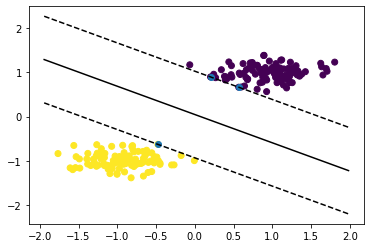

In [153]:
plot_svc(X, y, svc, pred)

The SVC separates very well the data, the support vectors appear in blue.

## Soft Margin Classifier with Linear Kernel 

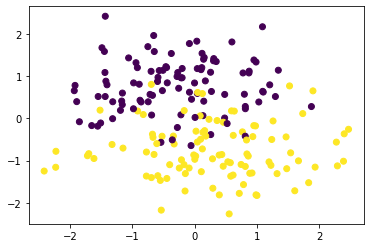

In [157]:
X, y = generate_data(n_samples=200, n_features=2, centers=2, center_box=(-5, 5), cluster_std=2.5)
plt.scatter(X[:, 0], X[:, 1], c=y)

This time we generated non separable data.

In [159]:
svc_soft = SupportVectorClassifier(linear_kernel, C=0.1)

     pcost       dcost       gap    pres   dres
 0: -4.2577e+01 -4.1240e+01  1e+03  3e+01  2e-15
 1: -7.5598e+00 -3.8621e+01  9e+01  1e+00  1e-15
 2: -5.1212e+00 -1.8202e+01  1e+01  3e-02  1e-15
 3: -6.0958e+00 -8.1423e+00  2e+00  4e-03  7e-16
 4: -6.7688e+00 -7.1911e+00  4e-01  5e-04  5e-16
 5: -6.8928e+00 -7.0247e+00  1e-01  1e-04  5e-16
 6: -6.9357e+00 -6.9653e+00  3e-02  2e-05  6e-16
 7: -6.9460e+00 -6.9522e+00  6e-03  3e-06  5e-16
 8: -6.9488e+00 -6.9489e+00  9e-05  4e-08  6e-16
 9: -6.9489e+00 -6.9489e+00  9e-07  4e-10  6e-16
Optimal solution found.


In [160]:
pred = svc_soft.predict(X)

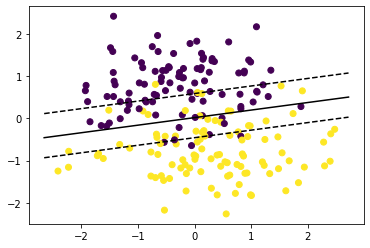

In [161]:
plot_svc(X, y, svc_soft, pred, plot_sv=False)

The soft margin classifier places the classification plane in the middle of the two cluster in the direction of highest variable. Well done !

## Hard Margin Classifier with Kernel RBF

In [186]:
def generate_non_linear(mean_1, mean_2, mean_3, mean_4, cov):
    """Generates non linear data from gaussian distributions
    
    Mean 1 to 4 is the generate 4 clusters and cov is their covariance matrix.
    """
    X_1 = np.random.multivariate_normal(mean_1, cov, 50)
    X_1 = np.vstack((X_1, np.random.multivariate_normal(mean_3, cov, 50)))
    y_1 = np.ones(len(X_1))
    X_2 = np.random.multivariate_normal(mean_2, cov, 50)
    X_2 = np.vstack((X_2, np.random.multivariate_normal(mean_4, cov, 50)))
    y_2 = np.ones(len(X_2)) * -1
    
    X = np.vstack([X_1, X_2])
    y = np.hstack([y_1, y_2])
    X = StandardScaler().fit_transform(X)
    return X, y

In [261]:
X, y = generate_non_linear(mean_1=[-2, 2], mean_2=[1, -1],
                           mean_3=[4, -4], mean_4=[-4, 4],
                           cov=[[1.0,0.8], [0.8, 1.0]])

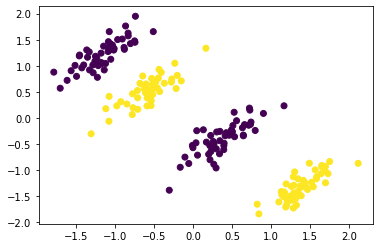

In [262]:
plt.scatter(X[:, 0], X[:, 1], c=y)

Evn the linear soft margin model cannot fit well this data. For solving this problem we will use the kernel radial basis function (RBF).

In [335]:
def polynomial_kernel(X_1, X_2, p):
    """Computes the polynomial kernel where p is the degree of the polynomial"""
    return (1 + np.dot(X_1, X_2)) ** p

def kernel_rbf(X_1, X_2, sigma=1.0):
    """Computes the kernel RBF where sigma is the bandwith"""
    return np.exp(-np.linalg.norm(X_1 - X_2) ** 2 / (2 * sigma ** 2))

In [336]:
svc_rbf = SupportVectorClassifier(kernel_rbf)
svc_rbf.fit(X, y)

     pcost       dcost       gap    pres   dres
 0: -1.5702e+01 -4.7310e+01  5e+02  2e+01  2e+00
 1: -7.4712e+00 -5.0258e+01  9e+01  3e+00  2e-01
 2: -1.0976e+01 -4.0857e+01  5e+01  1e+00  9e-02
 3: -1.9295e+01 -4.0147e+01  2e+01  1e-01  1e-02
 4: -2.7419e+01 -3.4022e+01  7e+00  1e-02  1e-03
 5: -3.0658e+01 -3.2568e+01  2e+00  2e-03  2e-04
 6: -3.1971e+01 -3.2192e+01  2e-01  2e-04  1e-05
 7: -3.2154e+01 -3.2158e+01  4e-03  2e-06  2e-07
 8: -3.2157e+01 -3.2157e+01  5e-05  2e-08  2e-09
 9: -3.2157e+01 -3.2157e+01  5e-07  2e-10  2e-11
Optimal solution found.


In [337]:
pred = svc_rbf.predict(X)

In [338]:
def plot_svc_rbf(X, y, svc):
    """Plots the hyperplane and margins of a SVC with rbf kernel"""
    plt.scatter(X[:, 0], X[:, 1], c=y)
    sv = svc.sv
    plt.scatter(sv[:, 0], sv[:, 1], c='g')
    axis_min, axis_max = plt.gca().get_xlim()
    
    X1, X2 = np.meshgrid(np.linspace(axis_min, axis_max, 50), np.linspace(axis_min, axis_max,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = svc.project(X).reshape(X1.shape)
    plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
    
    plt.axis("tight")
    plt.show()
    

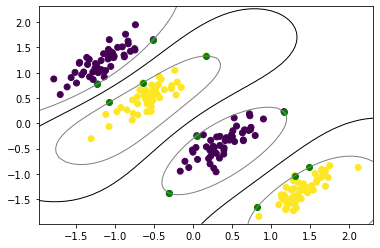

In [339]:
plot_svc_rbf(X, y, svc_rbf)

## Conclusion
Support Vector Machines have a variety of kernel to fit the most complex data. These work really well when there is a clear margin of separation between classes and are very effective on data with high dimensionality. Unfortunately, SVMs are not suited for large scale datasets due to their computational complexity. Furthermore, there is no probabilistic explanation of their prediction and they do not perform well on very noisy data.